In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
import math 


mpl.rcParams['figure.dpi'] = 120

#### Settings

In [2]:
# 1 inch = 0.0254 m so approximatively 0.025 m
# 10 inches = 0.25m 
# 1 hectare = 10000m^2 therefore 100m*100m
# 100m = 0.25m*400 = 10in * 400 = 4000in

P_max = 1600*.5 # Max number of dandelion heads that each dandelion flower head is 1in*1in. We multiply by .5 because otherwise the field would be too oversatured, and dandelions are still sread out
length = 50 # Shrunk from 400 to 50 therefore 80in by 80 in which is 1600 dandelions max
seeds_produced = (150+200)/2 # https://www.canr.msu.edu/weeds/extension/dandelion#:~:text=Seed%3A,because%20they%20move%20in%20updrafts. Around 200 seeds 
survival_rate = (float) (0.02+0.04)/2
n_heads = 10 # https://gardens.duke.edu/sites/default/files/Duke%20Gardens%20-%20Meet%20a%20Plant%20Dandelion.pdf: On average, a single dandelion plant can produce 10 flower heads.
'''
 In one experiment, a majority of seeds were consumed by ground beetles within 2 to 3 weeks after shedding, 
 but the 2-4% of viable seeds that remained were sufficient to maintain high soil populations (Honek et al. 2005).
https://cals.cornell.edu/weed-science/weed-profiles/dandelion
'''

moisture_level = (float) (1) 
sunlight_level = [0.395, 0.441, 0.5, 0.56, 0.615, 0.637, 0.62, 0.575, 0.516, 0.458, 0.404, 0.379]
# sunlight_level = (float) (1) # Sunlight stays constant throughout the year because we are considering avg sunlight 
# sunlight_level_winter = (float) (0.9)
angle = 195 # From Model 1 Average Angle is 195
# https://www.researchgate.net/figure/Variation-of-sunshine-hours-with-months-of-the-year_fig1_268330578 - avg sunshine duration is 5h / day throughout the year
# Max sunshine level https://en.wikipedia.org/wiki/Sunshine_duration#:~:text=The%20city%20claiming%20the%20official,sunnier%20areas%20in%20North%20Africa: 11h/day on avg
# However, we will assume 1 is that plants get enough sunlight, and 0 is that they don't get any sunlight 0-1

avg_rain = 5 # per month, assuming that each day of precipitation grants 1 moisture
avg_iteration = 1 # n of iterations per month 
'''
Direct sow from early March to early September. Optimal soil temperature for germination: 10-25°C (50-75°F). Seeds take 14-21 days to germinate. 
The flowering process begins 56 to 105 from sowing, and continues for the life of the plant. Therefore, we can only really have 1 iteration per month. 

https://www.westcoastseeds.com/blogs/wcs-academy/how-to-grow-dandelions 

Plants take 2 months to grow. Therefore, we will only add dandelions from previous month to our current month 
'''

'\nDirect sow from early March to early September. Optimal soil temperature for germination: 10-25°C (50-75°F). Seeds take 14-21 days to germinate. \nThe flowering process begins 56 to 105 from sowing, and continues for the life of the plant. Therefore, we can only really have 1 iteration per month. \n\nhttps://www.westcoastseeds.com/blogs/wcs-academy/how-to-grow-dandelions \n\nPlants take 2 months to grow. Therefore, we will only add dandelions from previous month to our current month \n'

#### Definitions

In [3]:
def set_wind(angle, wind):
    rad = math.radians(angle) # angle in deg
    relation = math.sin(rad)/math.cos(rad)
    print(relation)
    division_const = 3

    diagonal = [[0,0]]

    # if (angle > 90):
    #     wind = np.zeros((length+1, length+1))
    #     return

    if (angle <= 45):

        for j in range(1, length+1):
            y = (int) ((j*relation))
            if (y >= length+1):
                diagonal.append([-1, -1])
                continue
            diagonal.append([y, j])

            wind[y][j] = (float) ((j)/400)

        # Fill the rest

        #Proces upper diagonal 
        for j in range(length+1-1, -1, -1):
            for i in range(diagonal[j][0]+1, length+1):
                if (wind[i][j] == 0):
                    if (j+1 < length+1):
                        wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/(2+(i-diagonal[j][0]+1))

        #Process lower diagonal
        for j in range(1, length+1):
            for i in range(diagonal[j][0], -1, -1):
                if (wind[i][j] == 0):
                    wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/(2+(diagonal[j][0]-i))
    elif angle > 45 and angle <=90:

        wind = np.zeros((length+1, length+1))
        wind[0][0] = 0.001

        for i in range(1, length+1):
            x = (int) ((i/relation))
            if (x >= length+1):
                diagonal.append([-1, -1])
                continue
            diagonal.append([i, x])

            wind[i][x] = (float) ((i+1)/400)
        
        #Process upper diagonal
        for i in range(1, length+1):
            for j in range(diagonal[i][1], -1, -1):
                if (wind[i][j] == 0):
                    wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/(2+(diagonal[i][1]-j))

        out = False

        #Process lower diagonal
        for i in range(length+1-1, -1, -1):
            for j in range(diagonal[i][1]+1, length+1):
                if (wind[i][j] == 0):
                    if (i+1 < length+1):
                        wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/(2+(j-diagonal[i][1]+1))
    elif angle >= 180 and angle <=225:
        wind[0][0] = (float) (60/400)
        for j in range(1, length+1):
            y = (int) ((j*relation))
            if (y >= length+1):
                diagonal.append([-1, -1])
                continue
            diagonal.append([y, j])

            wind[y][j] = (float) ((60-j)/400)

        # Fill the rest

        #Proces upper diagonal 
        for j in range(length+1-1, -1, -1):
            for i in range(diagonal[j][0]+1, length+1):
                if (wind[i][j] == 0):
                    if (j+1 < length+1):
                        wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/(2+(i-diagonal[j][0]+1))

        #Process lower diagonal
        for j in range(1, length+1):
            for i in range(diagonal[j][0], -1, -1):
                if (wind[i][j] == 0):
                    wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/(2+(diagonal[j][0]-i))
    elif angle > 225 and angle <= 270:
        wind[0][0] = (float) (60/400)
        for i in range(1, length+1):
            x = (int) ((i/relation))
            if (x >= length+1):
                diagonal.append([-1, -1])
                continue
            diagonal.append([i, x])

            wind[i][x] = (float) ((60-i+1)/400)
        
        #Process upper diagonal
        for i in range(1, length+1):
            for j in range(diagonal[i][1], -1, -1):
                if (wind[i][j] == 0):
                    wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/(2+(diagonal[i][1]-j))

        out = False

        #Process lower diagonal
        for i in range(length+1-1, -1, -1):
            for j in range(diagonal[i][1]+1, length+1):
                if (wind[i][j] == 0):
                    if (i+1 < length+1):
                        wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/(2+(j-diagonal[i][1]+1))

In [4]:
def show(land, moisture, sunlight, wind, title):
    fig, (ax1, ax2) = plt.subplots(2, 2)
    im1 = ax1[0].imshow(land, origin='lower')
    ax1[0].set_title("Land Plot")
    im2 = ax1[1].imshow(moisture, origin='lower')
    ax1[1].set_title("Moisture")
    im3 = ax2[0].imshow(sunlight, origin='lower')
    ax2[0].set_title("Sunlight")
    im4 = ax2[1].imshow(wind, origin='lower')
    ax2[1].set_title("Wind")
    fig.tight_layout(pad=1.0)
    fig.suptitle(title)

    count = 1
    for i in range(1, 3):
        for j in range(2):
            divider = make_axes_locatable(eval("ax"+str(i)+"["+str(j)+"]"))
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(eval("im"+str(count)), cax=cax)
            count+=1


    plt.show()

In [5]:
def grass_prop(x, y, land):
    return 1-(land[x][y]/P_max)

def dandelion_prop(x, y, land):
    return (land[x][y]/P_max)

In [6]:
def update_moisture(moisture, land):
    # first we update moisture

    for i in range(len(moisture)):
        for j in range(len(moisture)):
            moisture[i][j] = moisture[i][j]+avg_rain*((float) (.1)) # Take into account all the precipitation

    for i in range(len(land)):
        for j in range(len(land)):
            moisture[i][j] = max(moisture[i][j] - (dandelion_prop(i,j,land) * 0.9), 0.0)
            moisture[i][j] = min(moisture[i][j], 1.0) # bring back moisture to 0 - 1 range once adjusted 

In [7]:
def update_sunlight(sunlight, month):

    for i in range(len(sunlight)):
        for j in range(len(sunlight)):
            sunlight[i][j] = sunlight_level[month-1]

#### Variables

In [8]:

land = np.zeros((length, length))
land[0][0] = 1 #initial dandelion

# Defining wind as a NE direction for matrix
wind = np.zeros((length+1, length+1))
wind[0][0] = 0.001
set_wind(angle, wind)
# Set length = length+1 to make it easier to calculate in the future 


moisture = np.full((length, length), moisture_level) 
sunlight = np.zeros((length, length))

0.26794919243112275


#### Code

In [9]:
# print(len(wind[400]))

getout = False
count = 0

months = []

pending_seeds = np.zeros((length, length)) # received seeds
pending_seeds2 = np.zeros((length, length)) # received seeds 2 Takes 2 months to grow

for month in range(1, 13):
    # set_wind(angles[month-1], wind)
    print("month ", month)

    update_sunlight(sunlight, month)
    
    for it in range(avg_iteration):
        # For each square, determine the number of seeds and check seed transfer based on the wind direction. 

        seeds = np.zeros((length, length)) 

        # Convert seeds to dandelions 
        for i in range(length):
            for j in range(length):
                land[i][j] = min(P_max, round((land[i][j]+n_heads*pending_seeds2[i][j]*moisture[i][j]*(sunlight[i][j]/.5))))
        
        update_moisture(moisture, land)

        for i in range(length):
            for j in range(length):
                right = min(j+1, length) # Don't go out of bounds (doesn't happen but as backup)
                top = min(i+1, length)

                wind_sum = 0

                for y in range(2):
                    for x in range(2):
                        if (i+y < length and j+x<length):
                            wind_sum+=wind[i+y][j+x]


                total_seeds = seeds[i][j] + (int) (land[i][j]*seeds_produced*survival_rate)
                # seeds[i][j] += transfered_seeds[i][j]
                
                if (wind_sum == 0):
                    seeds[i][j] = total_seeds

                else:
                    seeds[i][j] = round((wind[i][j]/wind_sum)*total_seeds)
                    total_give = 0

                    for y in range(2):
                        for x in range(2):
                            if (i+y < length and j+x<length):
                                seeds[i+y][j+x] = round((wind[i+y][j+x]/wind_sum)*total_seeds)

        pending_seeds2 = pending_seeds.copy()        
        pending_seeds = seeds.copy()
        

        #         count+=1
                
        #         if (count==1):
        #             getout = True
        #             break
        #     if getout:
        #         break
        # if getout: break

        # print(seeds)
        # Convert seeds to dandelions:

        
        
        
    

    months.append([land.copy(), moisture.copy(), sunlight.copy(), wind.copy()])
                
                
            


month  1
month  2
month  3
month  4
month  5
month  6
month  7
month  8
month  9
month  10
month  11
month  12


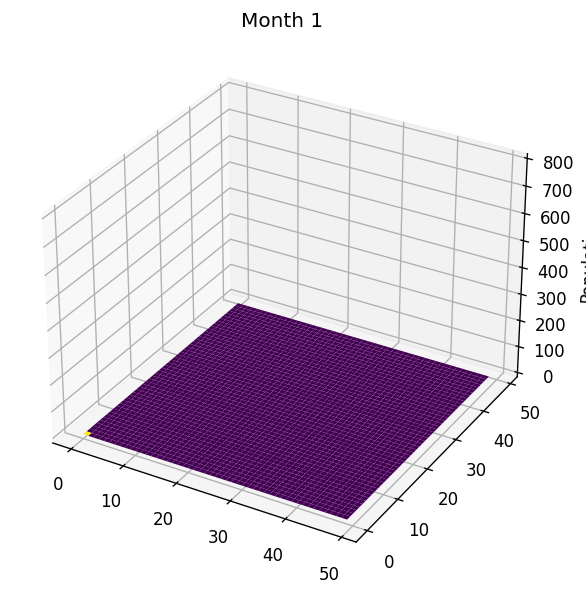

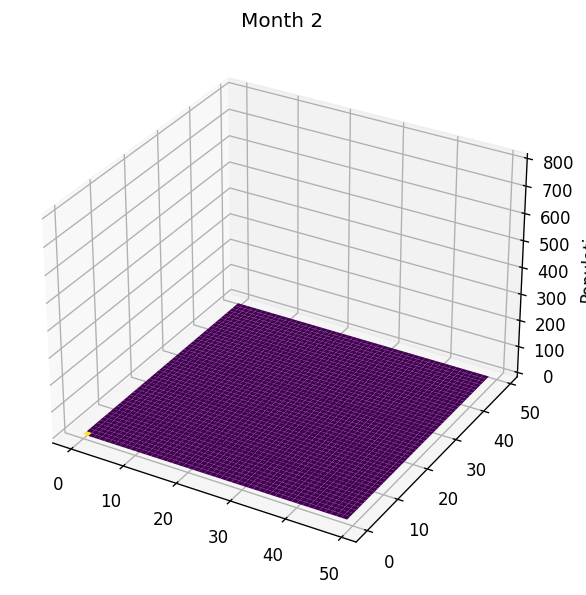

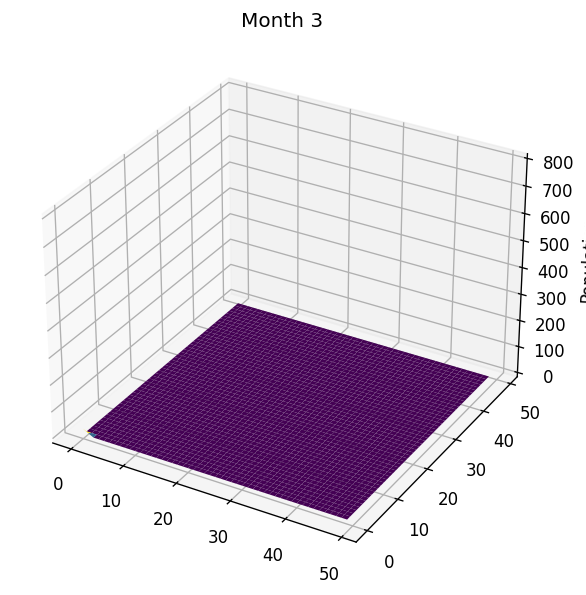

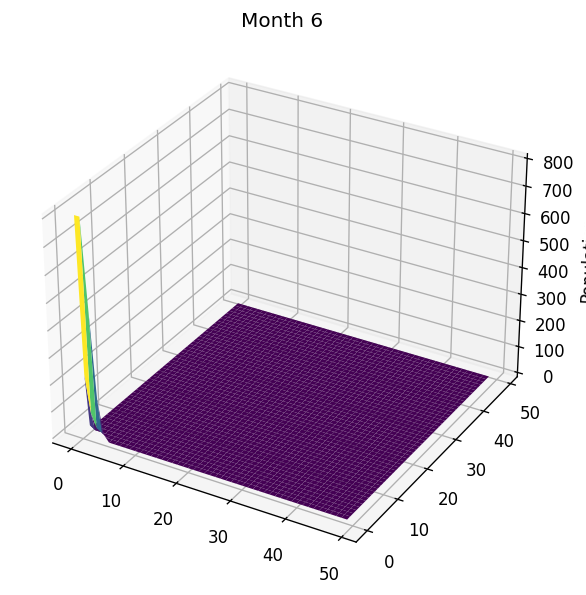

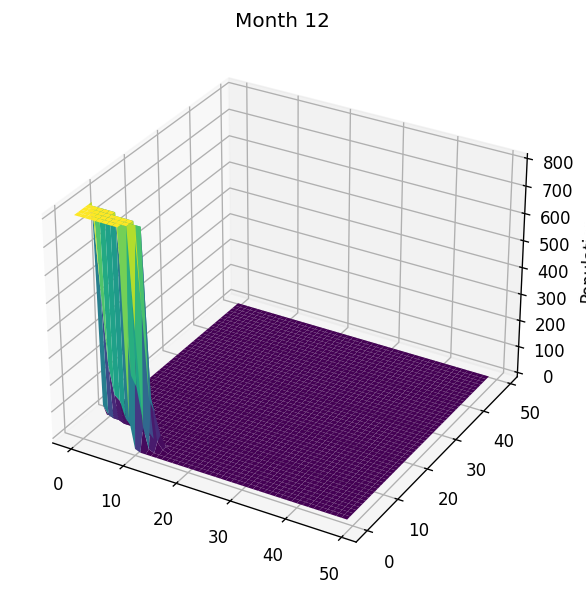

In [13]:
wanted = [1,2,3,6,12]

for i in range(len(months)):
    if ((i+1) in wanted):
        # show(months[i][0], months[i][1], months[i][2], months[i][3], "Month "+str(i+1))

        x = np.arange(0, length, 1)
        y = np.arange(0, length, 1)
        x,y  = np.meshgrid(x, y)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.tight_layout()
        # ax.invert_xaxis()
        ax.plot_surface(x,y,months[i][0], cmap='viridis')
        ax.set_title("Month "+str(i+1))
        ax.set_zlabel("Population")
        ax.set_zlim(0, 800)

In [11]:
# wanted = [1,2,3,6,12]
# maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']


# for i in range(len(months)):
#     if ((i+1) in wanted):
#         show(months[i][0], months[i][1], months[i][2], months[i][3], "Month "+str(i+1))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# idx = 0

# for i in range(len(months)):
#     if ((i+1) in wanted):
#         x = np.arange(0, length, 1)
#         y = np.arange(0, length, 1)
#         x,y  = np.meshgrid(x, y)

#         # ax.invert_xaxis()
#         ax.plot_surface(x,y,months[i][0], cmap=maps[idx])

#         idx+=1
